In [1]:
import pyspark
import pyspark.sql  as pyspark_sql
import pyspark.sql.types as pyspark_types
import pyspark.sql.functions  as pyspark_functions
from pyspark import SparkContext, SparkConf
from pandas import isnull
from numpy import count_nonzero
from pyspark.sql.functions import col, count, isnan, when, coalesce, lag, lead, sum
from pyspark.sql.window import Window

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

concatenated_dataset = pd.read_csv("D:/IIT/2 nd Year/2nd Sem/Data Engineering/Course Work/HCHO_Prediction/preprocessed dataset/concatenated_dataset.csv")

In [3]:
concatenated_dataset

HCHO Reading             Location Current Date   Next Date
0          0.000263     Deniyaya, Matara   2019-01-01  2019-01-02
1          0.000263  Nuwara Eliya Proper   2019-01-01  2019-01-02
2          0.000263       Colombo Proper   2019-01-02  2019-01-03
3          0.000006     Deniyaya, Matara   2019-01-02  2019-01-03
4          0.000006  Nuwara Eliya Proper   2019-01-02  2019-01-03
...             ...                  ...          ...         ...
12774      0.000158    Kurunegala Proper   2023-12-30  2023-12-31
12775      0.000117        Jaffna Proper   2023-12-30  2023-12-31
12776      0.000117   Bibile, Monaragala   2023-12-31  2024-01-01
12777      0.000065    Kurunegala Proper   2023-12-31  2024-01-01
12778      0.000065        Jaffna Proper   2023-12-31  2024-01-01

[12779 rows x 4 columns]

In [4]:
import pandas as pd

concatenated_dataset['Current Date'] = pd.to_datetime(concatenated_dataset['Current Date'])
concatenated_dataset['Next Date'] = pd.to_datetime(concatenated_dataset['Next Date'])

In [5]:
# Extracting year and month for seasonal analysis
concatenated_dataset['Year'] = concatenated_dataset['Current Date'].dt.year
concatenated_dataset['Month'] = concatenated_dataset['Current Date'].dt.month

In [6]:
# Grouping data by year and month for seasonal analysis
seasonal_data = concatenated_dataset.groupby(['Year', 'Month'])['HCHO Reading'].mean().reset_index()

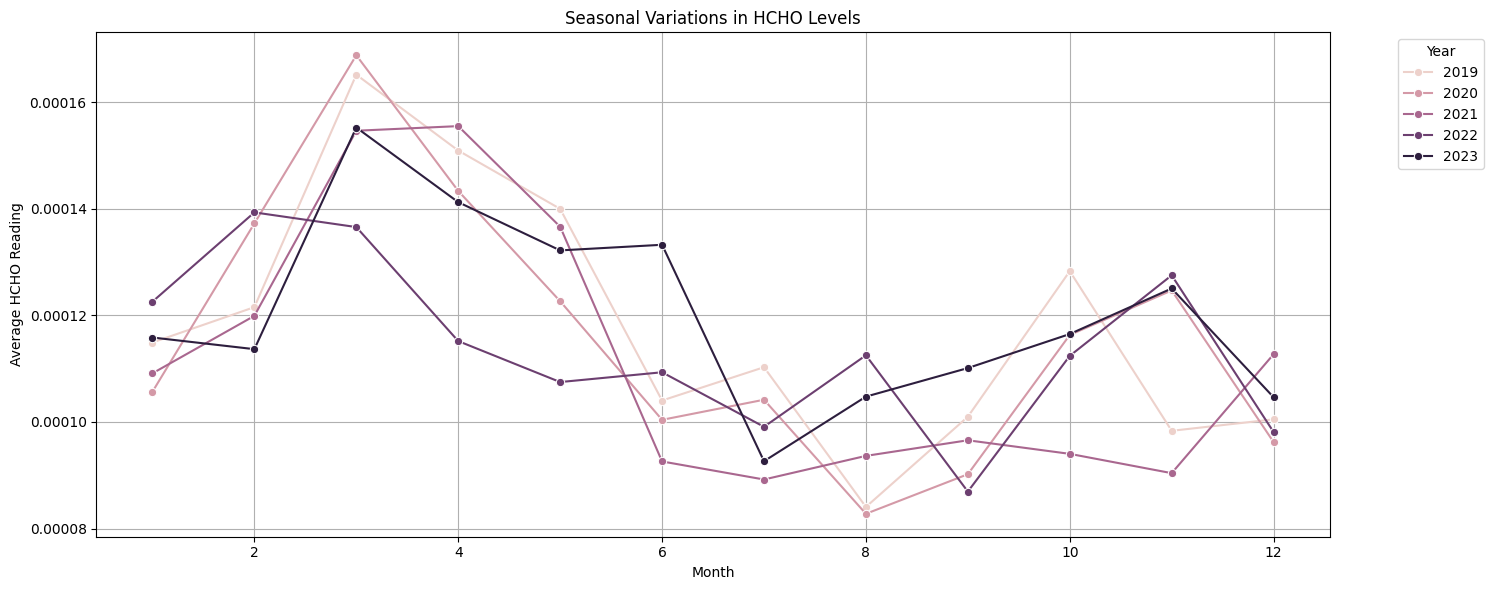

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting seasonal variations
plt.figure(figsize=(15, 6))
sns.lineplot(x="Month", y="HCHO Reading", hue="Year", data=seasonal_data, marker='o')
plt.title('Seasonal Variations in HCHO Levels')
plt.xlabel('Month')
plt.ylabel('Average HCHO Reading')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

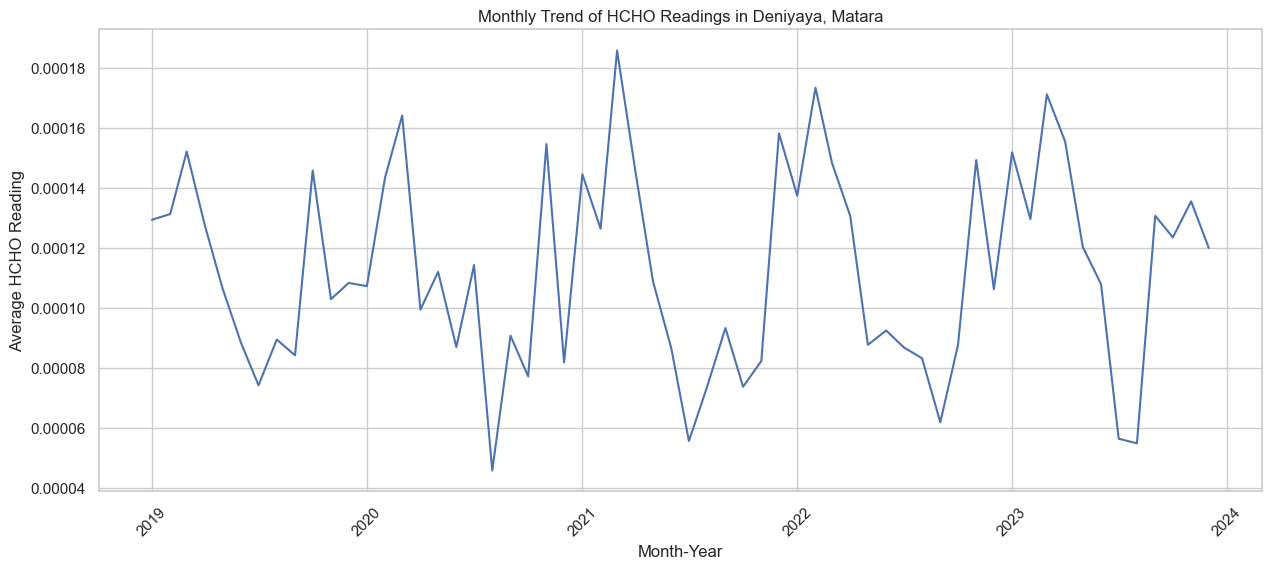

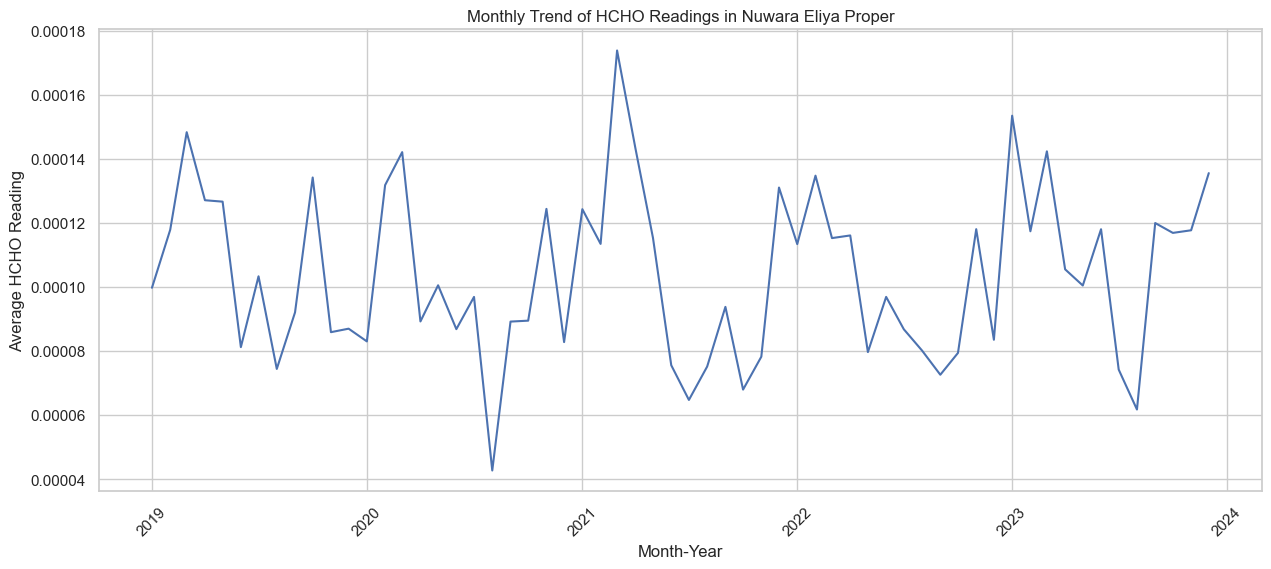

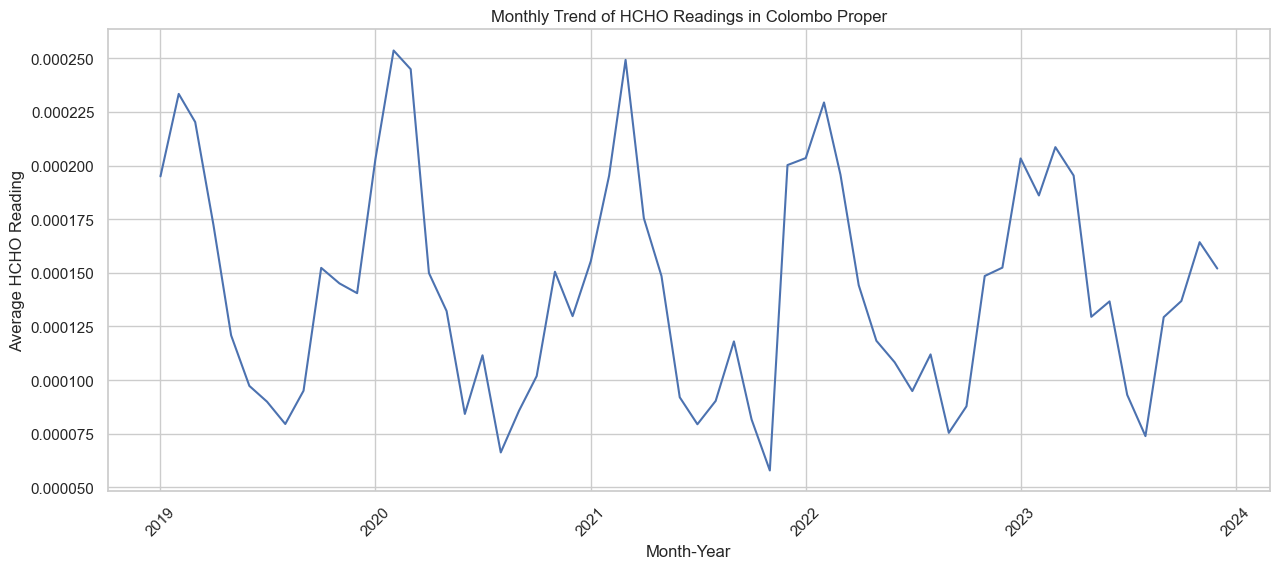

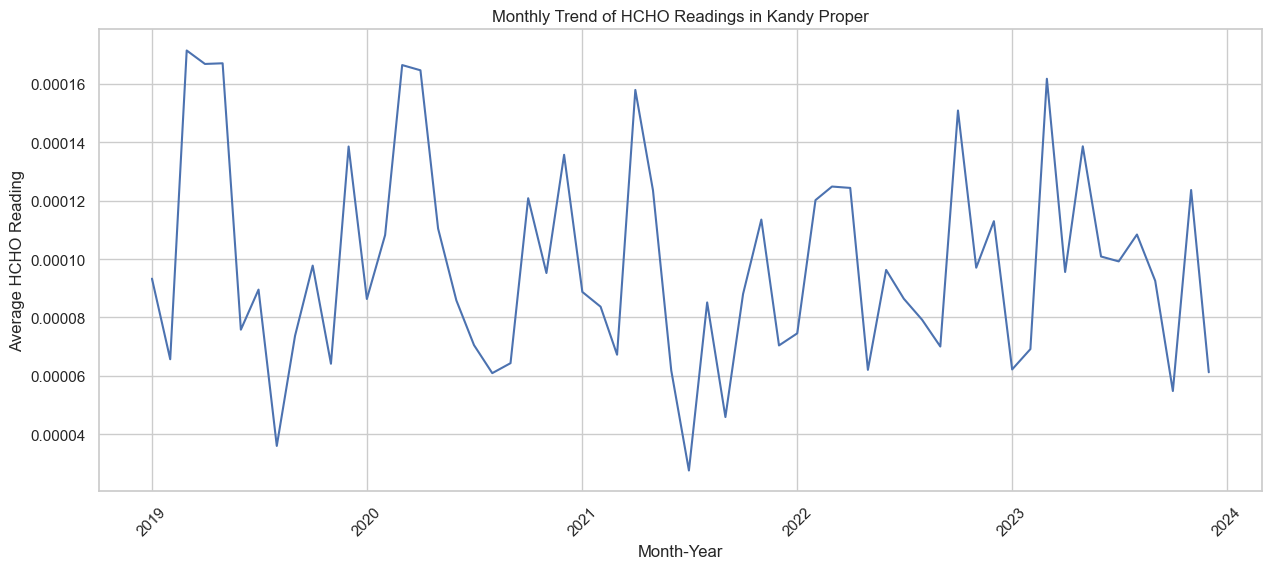

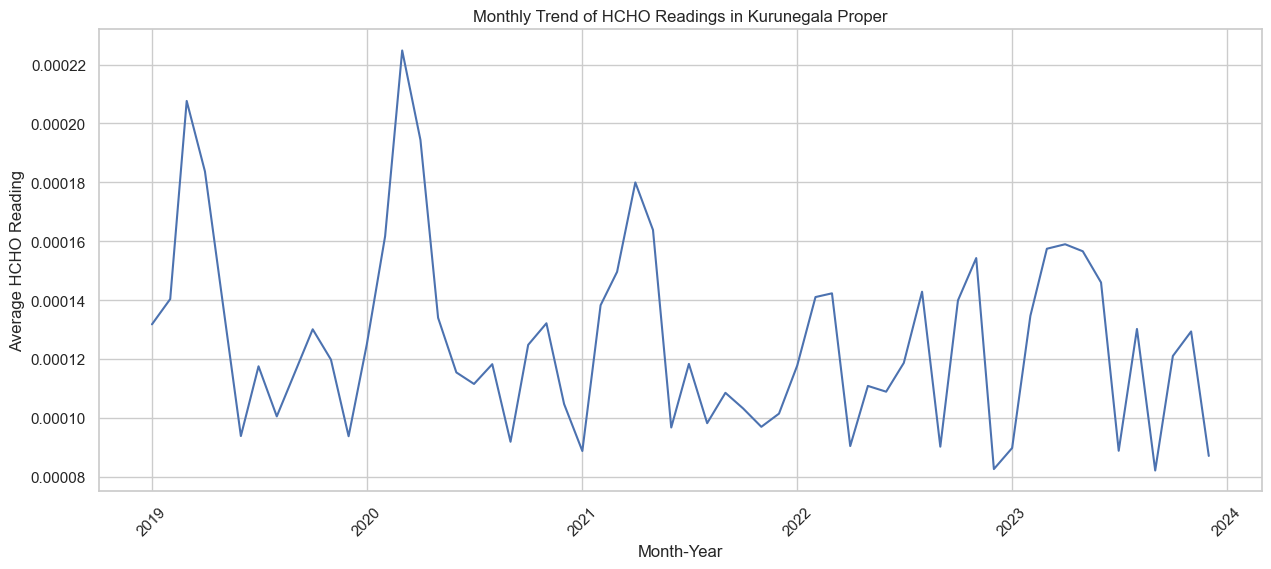

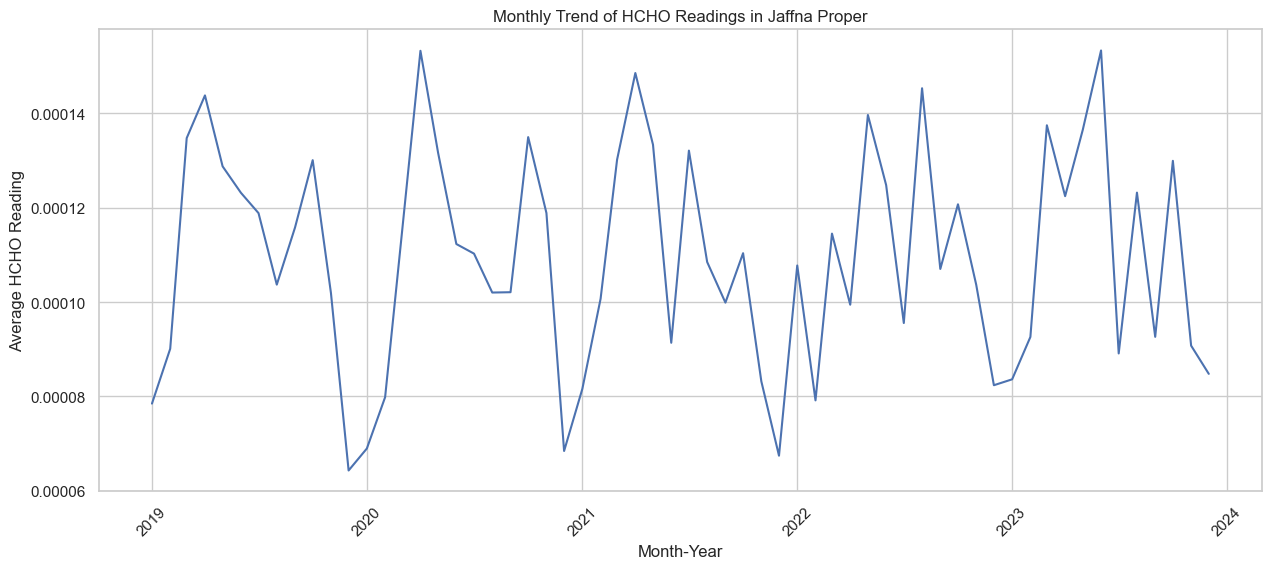

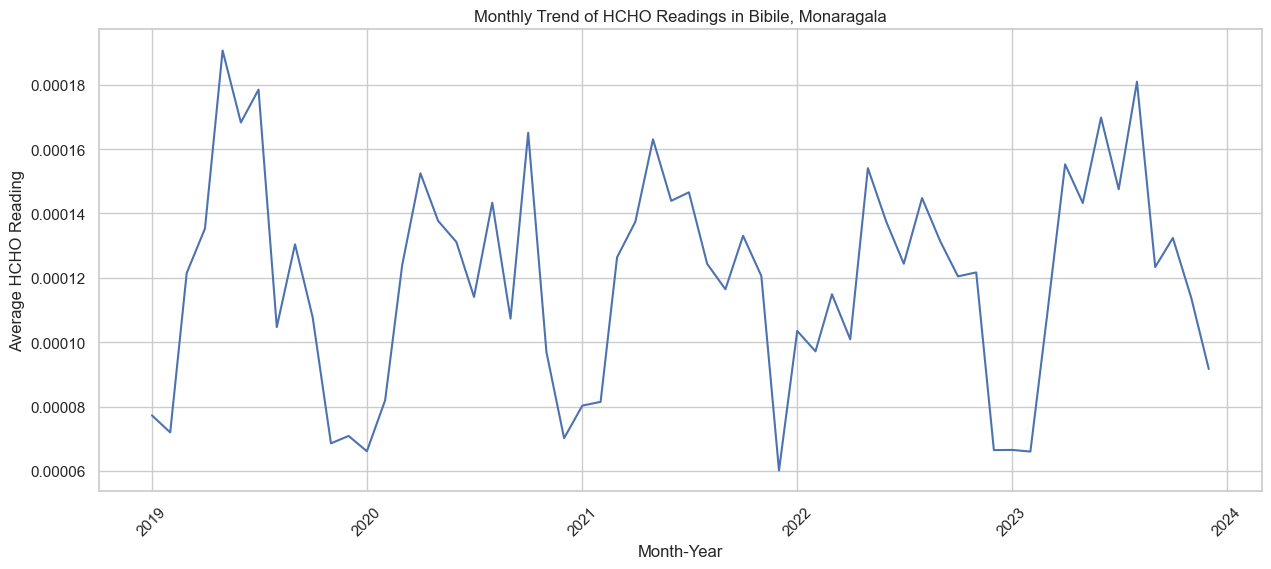

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Aggregating the HCHO readings on a monthly basis
concatenated_dataset['Month-Year'] = concatenated_dataset['Current Date'].dt.to_period('M')
monthly_data = concatenated_dataset.groupby('Month-Year')['HCHO Reading'].mean().reset_index()

# Converting 'Month-Year' back to datetime for plotting
monthly_data['Month-Year'] = monthly_data['Month-Year'].dt.to_timestamp()

for city in concatenated_dataset['Location'].unique():
    city_data = concatenated_dataset[concatenated_dataset['Location'] == city]
    monthly_data = city_data.groupby('Month-Year')['HCHO Reading'].mean().reset_index()
    monthly_data['Month-Year'] = monthly_data['Month-Year'].dt.to_timestamp()

    # Plotting the monthly trend of HCHO readings
    plt.figure(figsize=(15, 6))
    sns.lineplot(x='Month-Year', y='HCHO Reading', data=monthly_data)
    plt.title(f'Monthly Trend of HCHO Readings in {city}')
    plt.xlabel('Month-Year')
    plt.ylabel('Average HCHO Reading')
    plt.xticks(rotation=45)
    plt.show()


In [19]:
concatenated_dataset

HCHO Reading             Location Current Date  Next Date  Year  Month  \
0          0.000263     Deniyaya, Matara   2019-01-01 2019-01-02  2019      1   
1          0.000263  Nuwara Eliya Proper   2019-01-01 2019-01-02  2019      1   
2          0.000263       Colombo Proper   2019-01-02 2019-01-03  2019      1   
3          0.000006     Deniyaya, Matara   2019-01-02 2019-01-03  2019      1   
4          0.000006  Nuwara Eliya Proper   2019-01-02 2019-01-03  2019      1   
...             ...                  ...          ...        ...   ...    ...   
12774      0.000158    Kurunegala Proper   2023-12-30 2023-12-31  2023     12   
12775      0.000117        Jaffna Proper   2023-12-30 2023-12-31  2023     12   
12776      0.000117   Bibile, Monaragala   2023-12-31 2024-01-01  2023     12   
12777      0.000065    Kurunegala Proper   2023-12-31 2024-01-01  2023     12   
12778      0.000065        Jaffna Proper   2023-12-31 2024-01-01  2023     12   

      Month-Year  
0        2019-01  
1        2019-01  
2        2019-01  
3        2019-01  
4        2019-01  
...          ...  
12774    2023-12  
12775    2023-12  
12776    2023-12  
12777    2023-12  
12778    2023-12  

[12779 rows x 7 columns]

In [20]:
concatenated_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12779 entries, 0 to 12778
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   HCHO Reading  12779 non-null  float64       
 1   Location      12779 non-null  object        
 2   Current Date  12779 non-null  datetime64[ns]
 3   Next Date     12779 non-null  datetime64[ns]
 4   Year          12779 non-null  int32         
 5   Month         12779 non-null  int32         
 6   Month-Year    12779 non-null  period[M]     
dtypes: datetime64[ns](2), float64(1), int32(2), object(1), period[M](1)
memory usage: 599.1+ KB


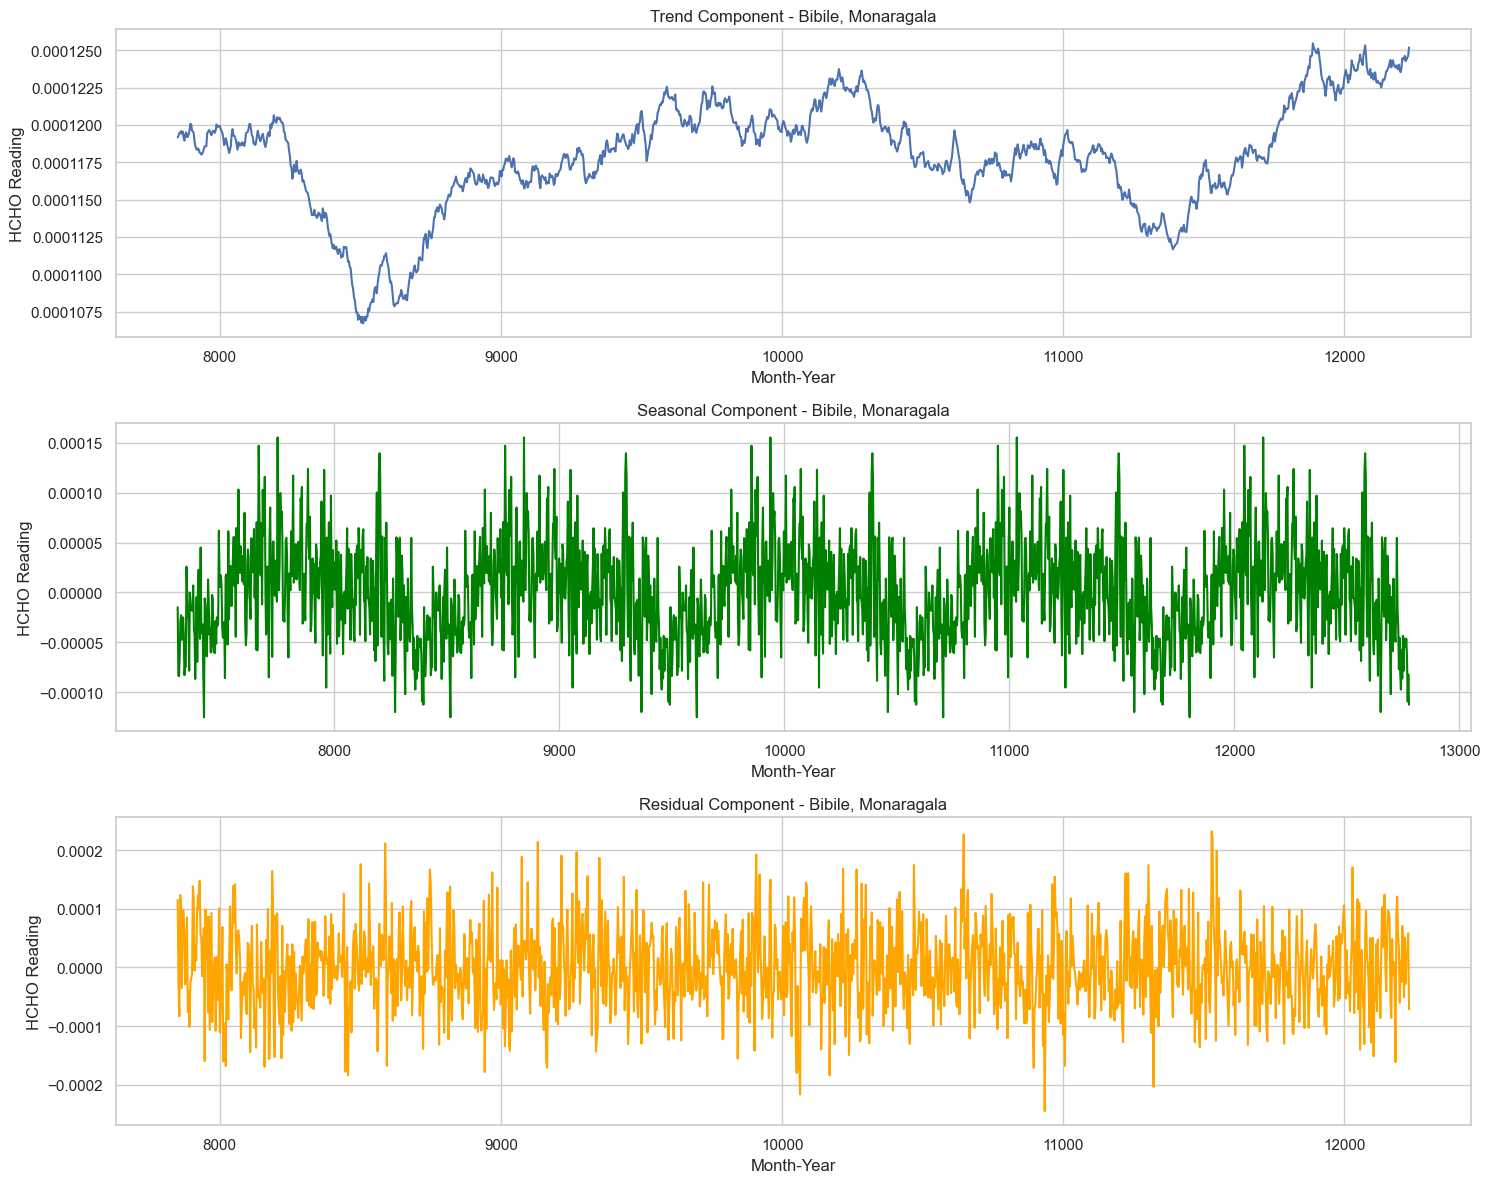

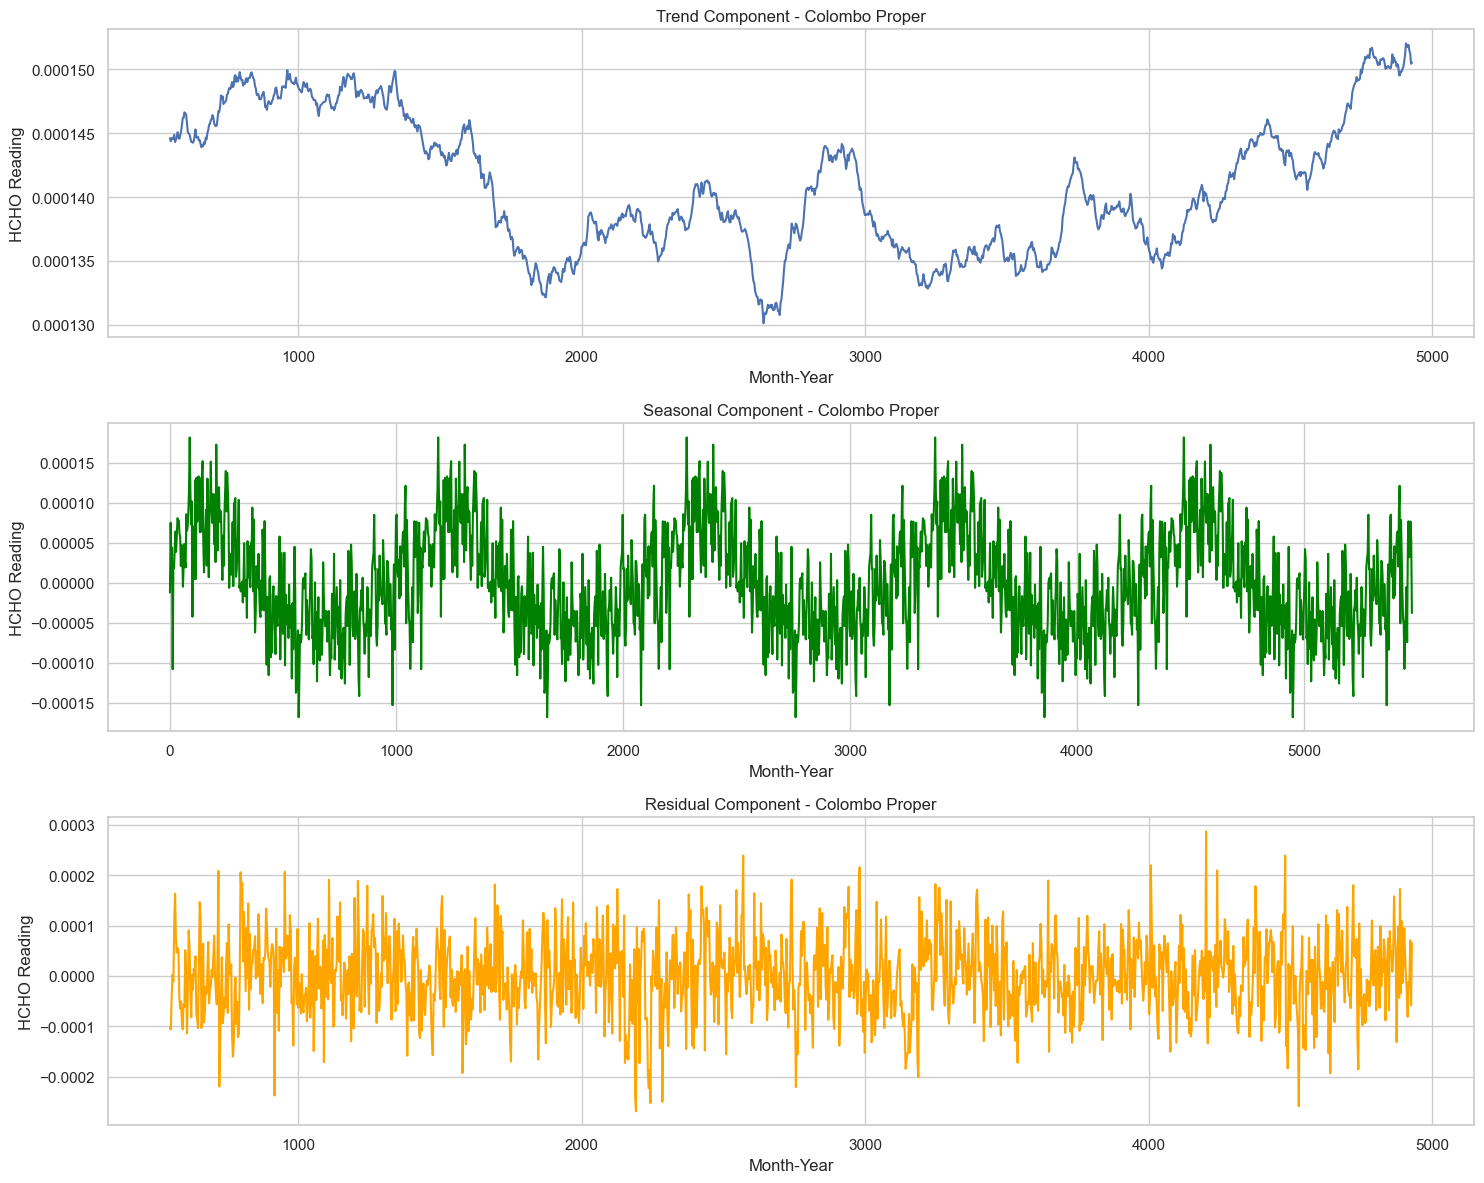

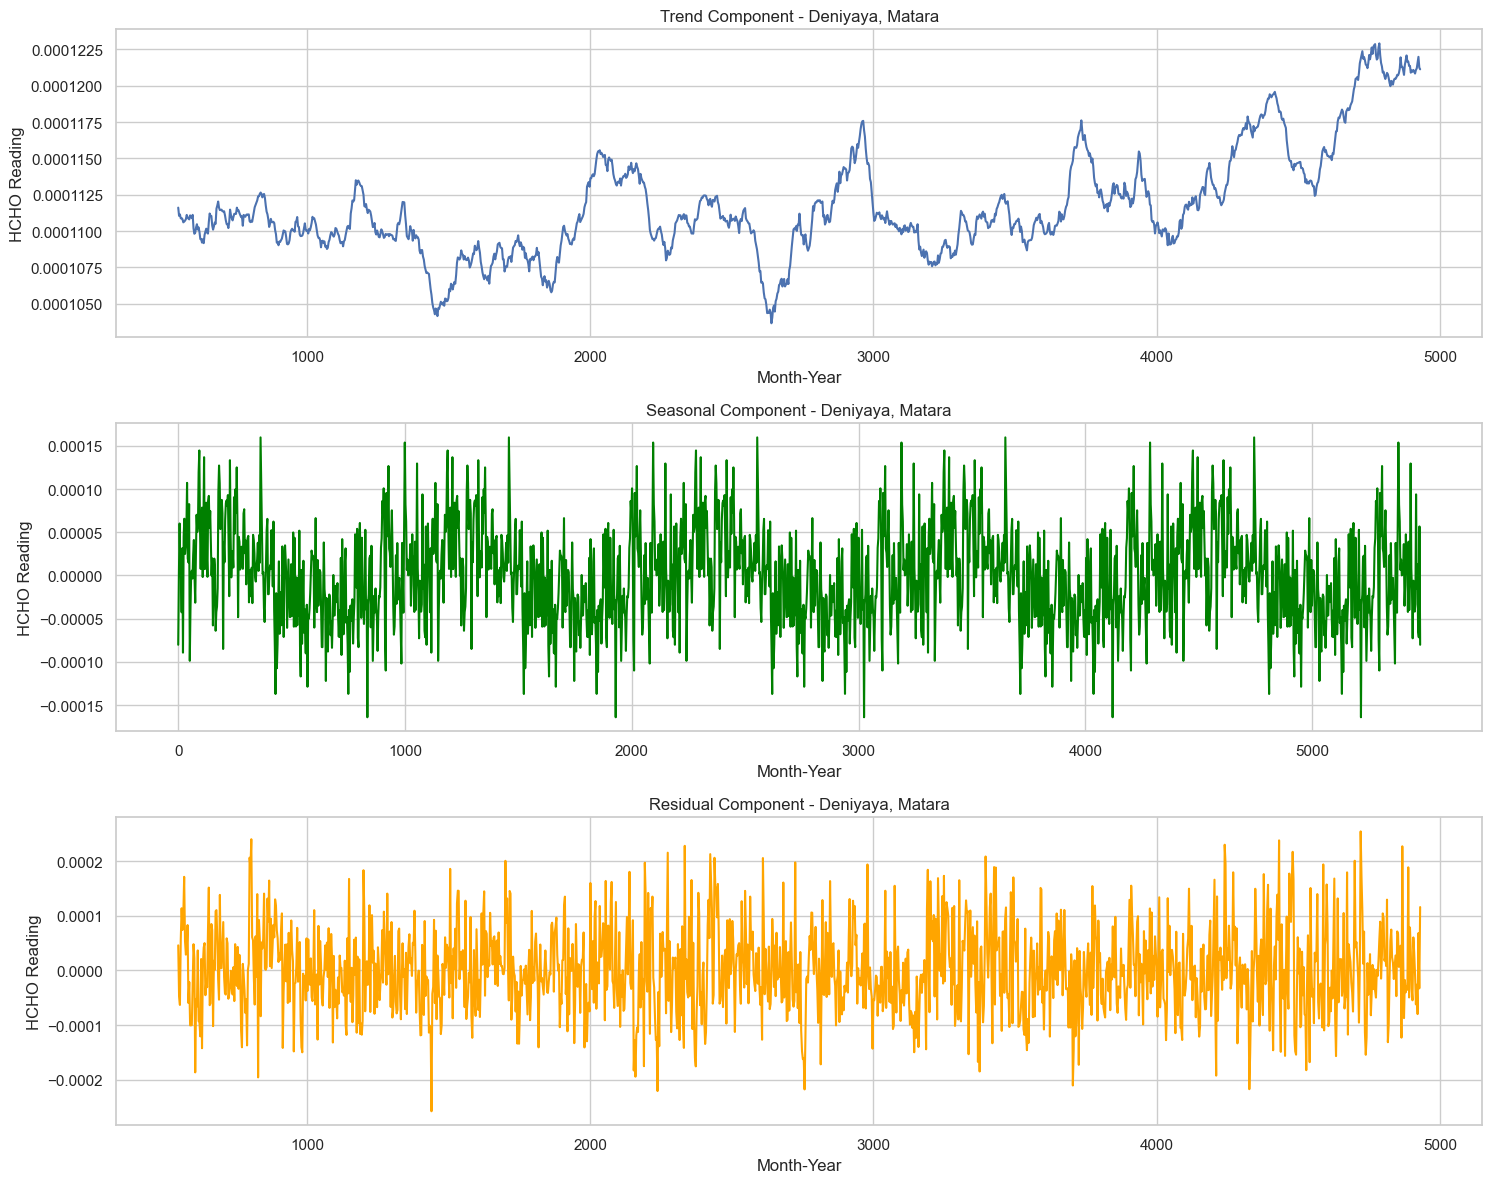

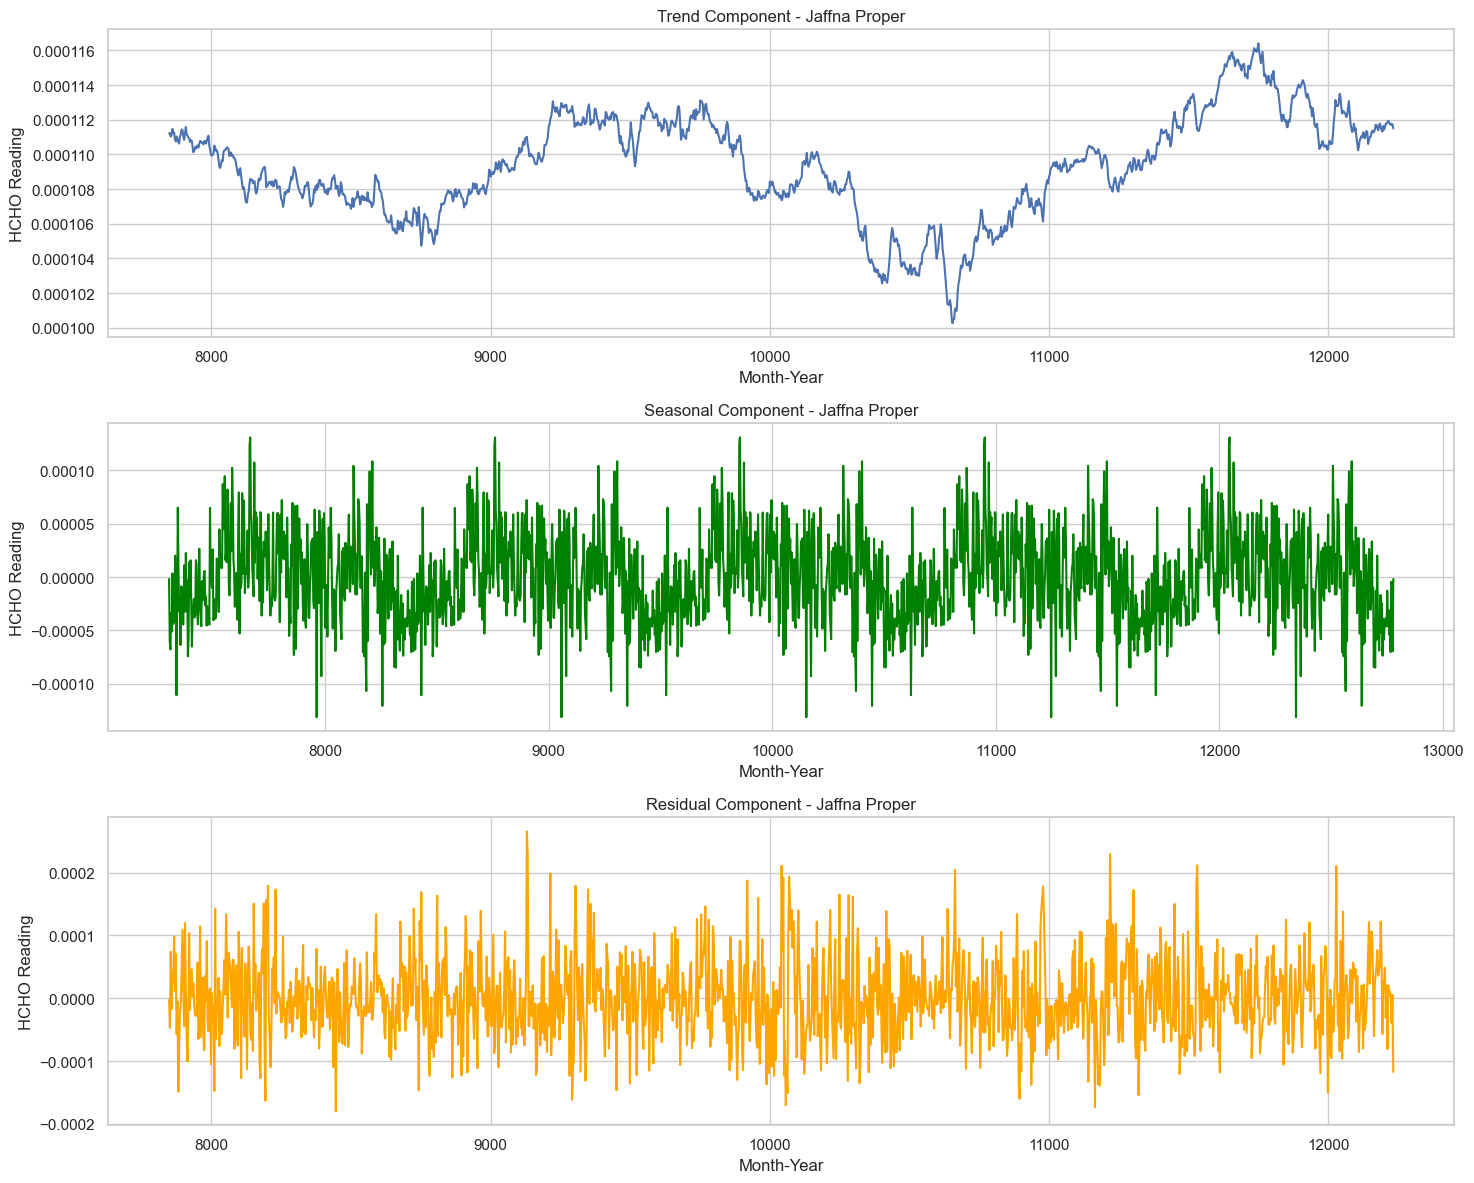

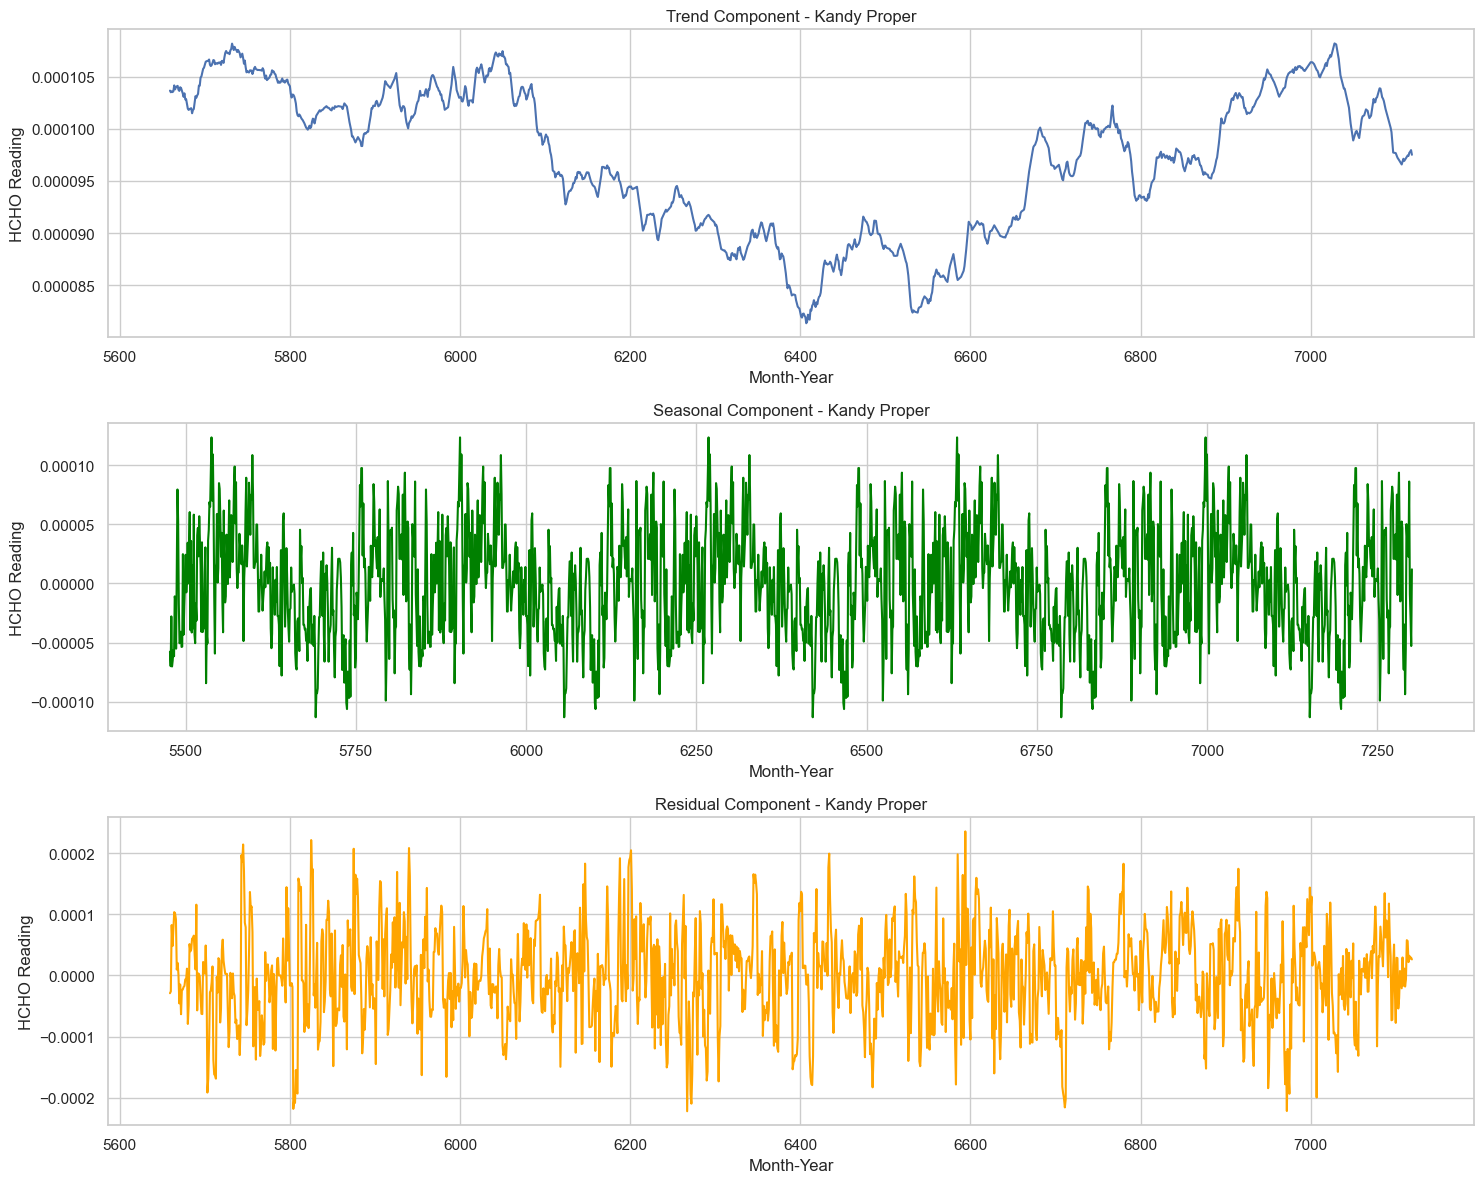

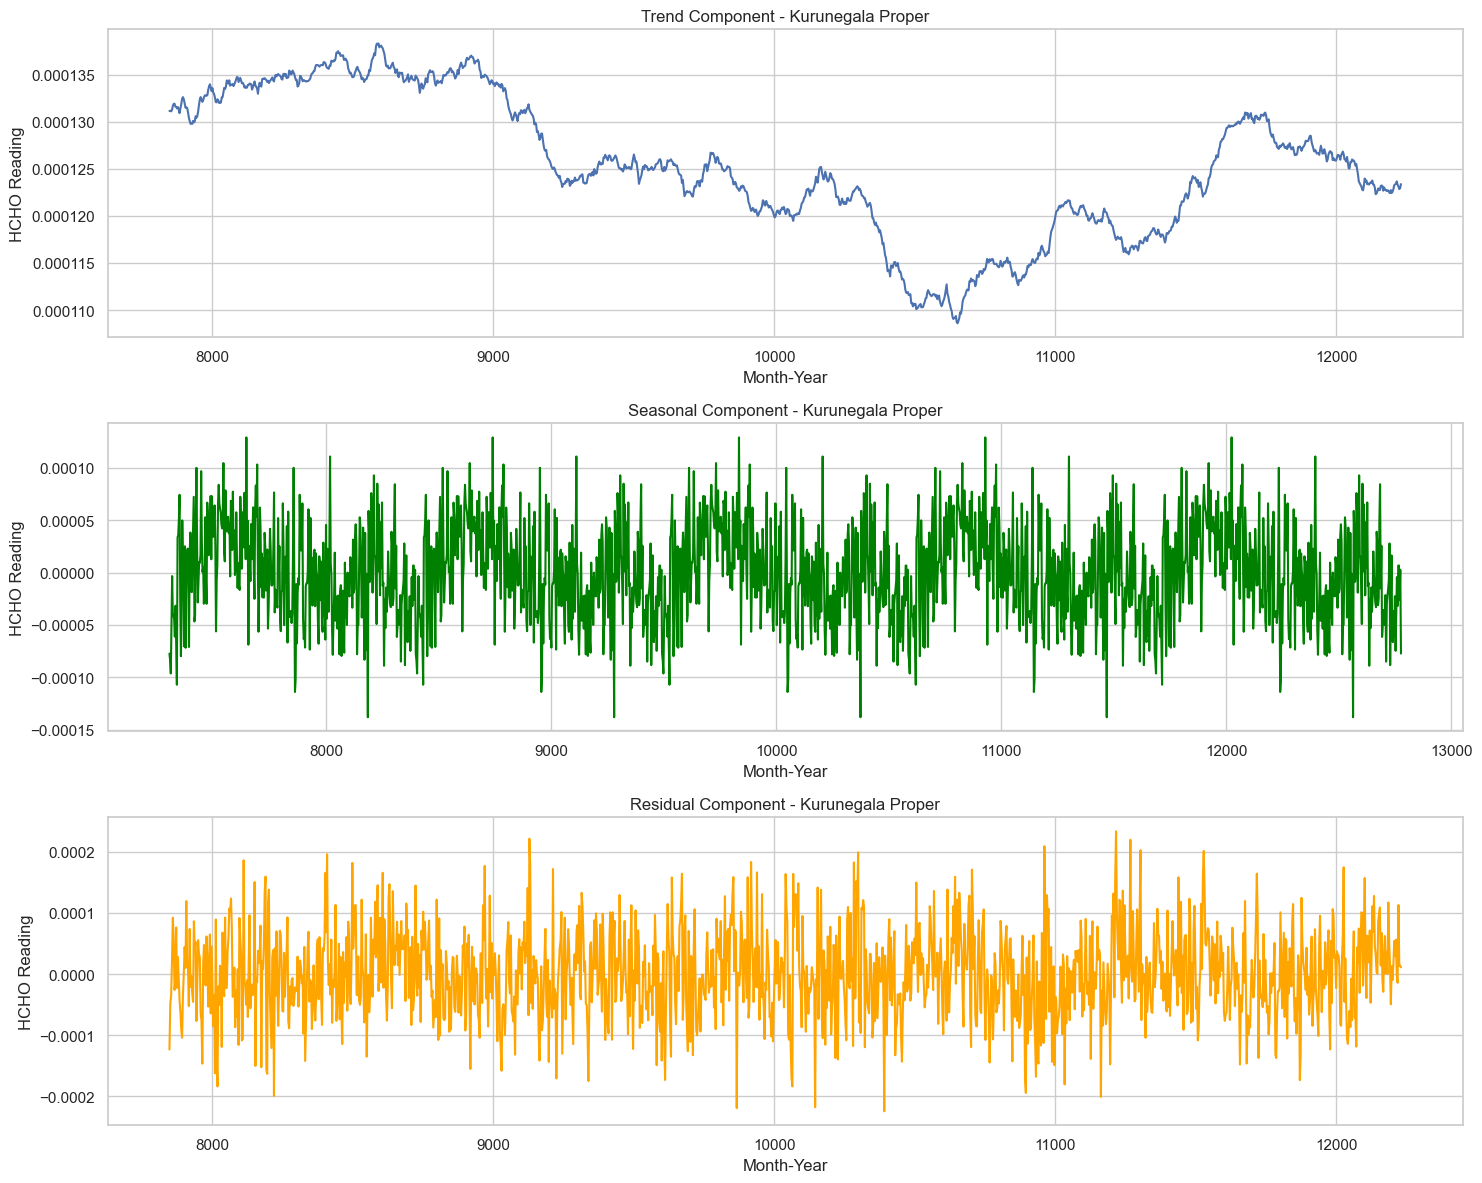

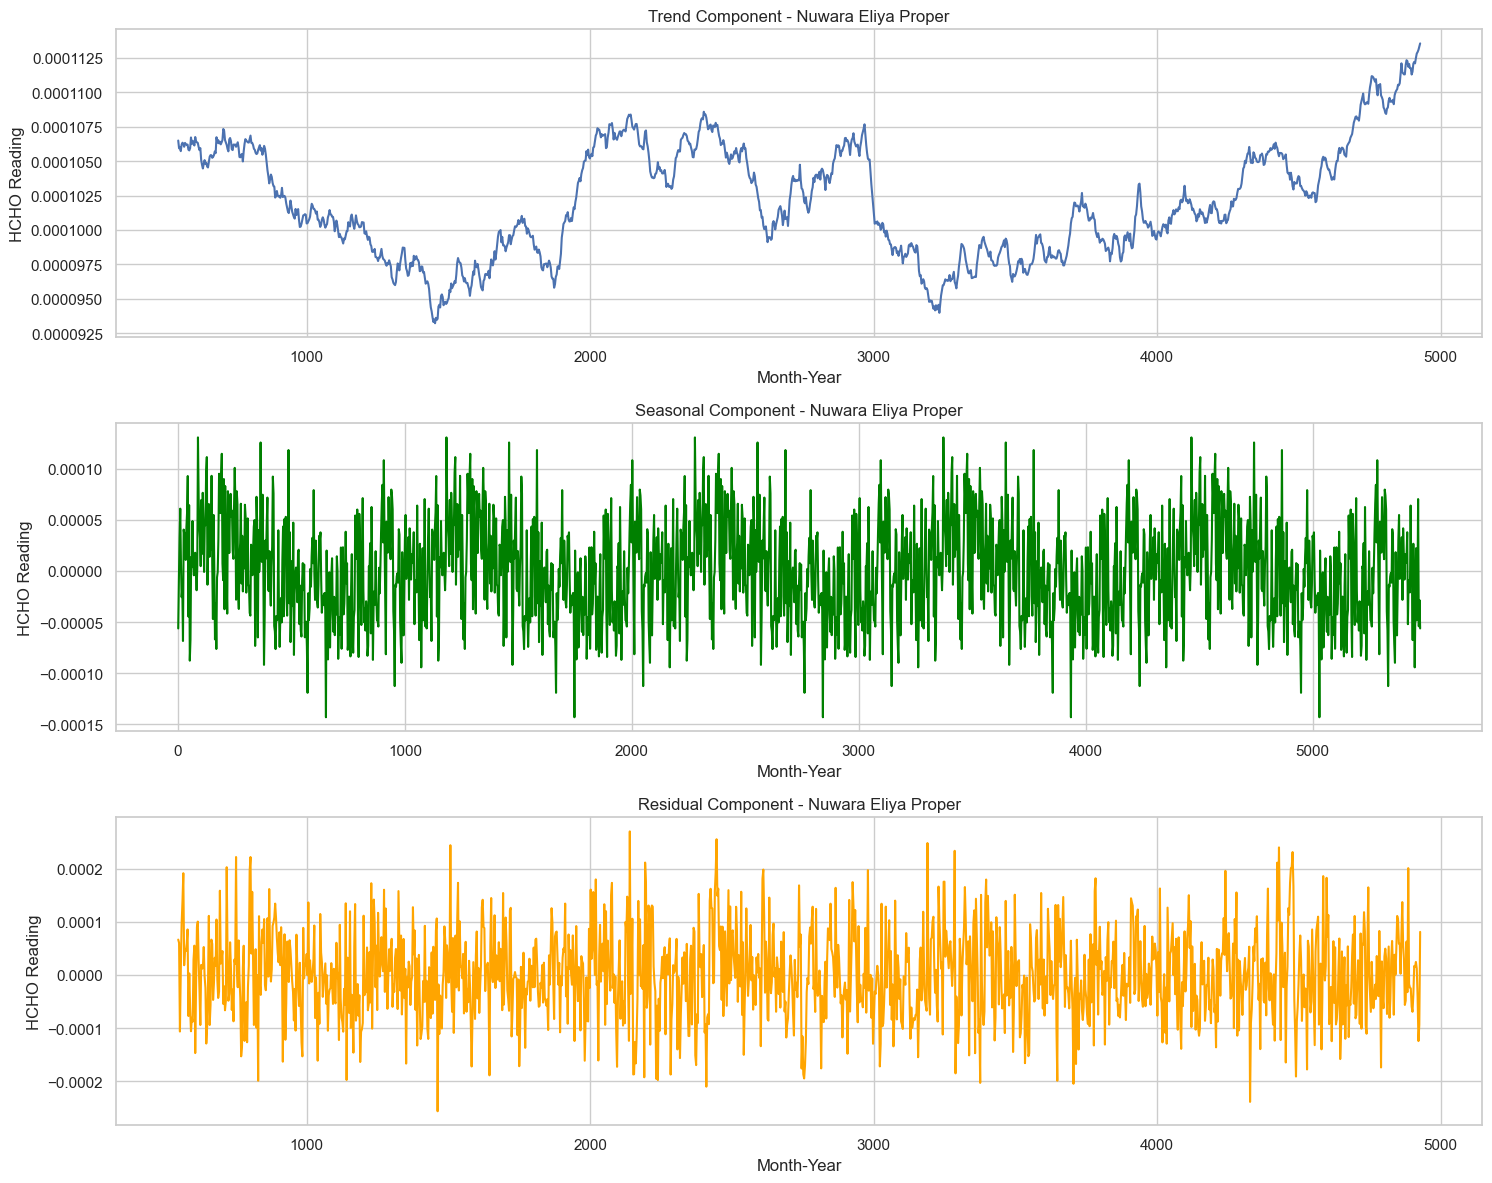

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Grouping the data by location
grouped_data = concatenated_dataset.groupby('Location')

# Decomposing the time series for each city
for city, data in grouped_data:
    # Ensure the index is sorted
    data = data.sort_index()

    # Decomposing the time series
    decomposition = seasonal_decompose(data['HCHO Reading'], model='additive', period=365)

    # Plotting the decomposed components
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
    decomposition.trend.plot(ax=ax1, title=f'Trend Component - {city}')
    ax1.set_ylabel('HCHO Reading')
    ax1.set_xlabel('Month-Year')

    decomposition.seasonal.plot(ax=ax2, title=f'Seasonal Component - {city}', color='green')
    ax2.set_ylabel('HCHO Reading')
    ax2.set_xlabel('Month-Year')

    decomposition.resid.plot(ax=ax3, title=f'Residual Component - {city}', color='orange')
    ax3.set_ylabel('HCHO Reading')
    ax3.set_xlabel('Month-Year')

    plt.tight_layout()
    plt.show()

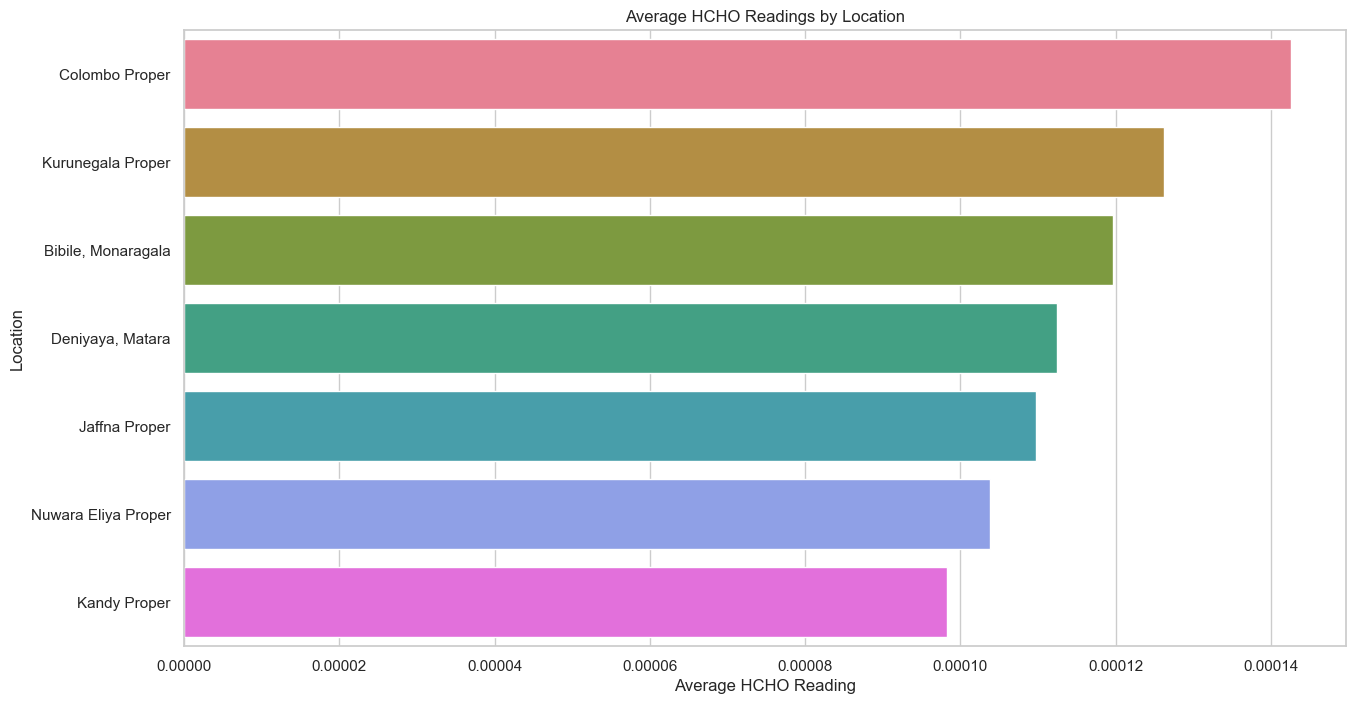

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Grouping the data by location and aggregating HCHO readings
city_data = concatenated_dataset.groupby('Location')['HCHO Reading'].mean().sort_values(ascending=False).reset_index()

# Define a custom color palette with different colors for each city
custom_palette = sns.color_palette("husl", len(city_data))

# Plotting the HCHO levels for different cities with custom colors
plt.figure(figsize=(15, 8))
sns.barplot(x='HCHO Reading', y='Location', data=city_data, palette=custom_palette)
plt.title('Average HCHO Readings by Location')
plt.xlabel('Average HCHO Reading')
plt.ylabel('Location')
plt.show()

In [14]:
# Long-term trend analysis
long_term_trend = concatenated_dataset.groupby('Year')['HCHO Reading'].mean().reset_index()


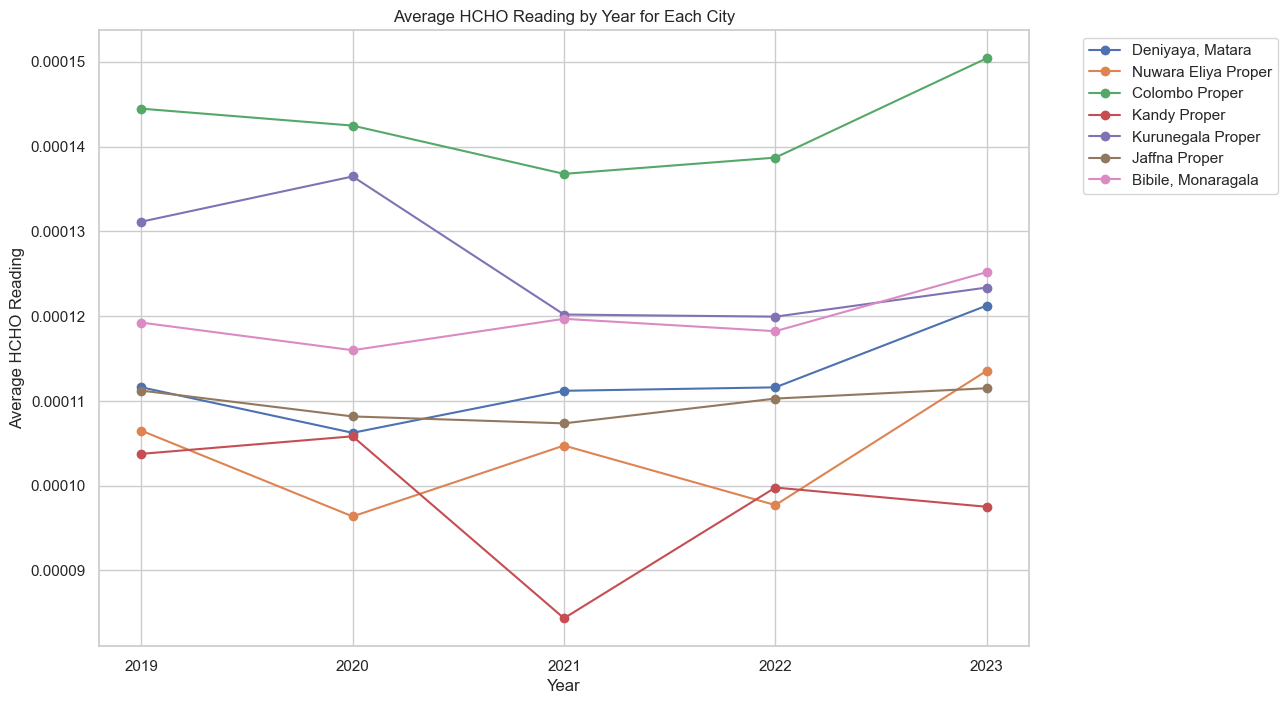

In [15]:
unique_cities = concatenated_dataset['Location'].unique()
plt.figure(figsize=(12, 8))
for city in unique_cities:
    city_data = concatenated_dataset[(concatenated_dataset['Location'] == city)]
    yearly_avg_hcho = city_data.groupby('Year')['HCHO Reading'].mean()
    plt.plot(yearly_avg_hcho.index, yearly_avg_hcho.values, marker='o', linestyle='-', label=city)

plt.title('Average HCHO Reading by Year for Each City')
plt.xlabel('Year')
plt.ylabel('Average HCHO Reading')
plt.xticks(yearly_avg_hcho.index)  
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

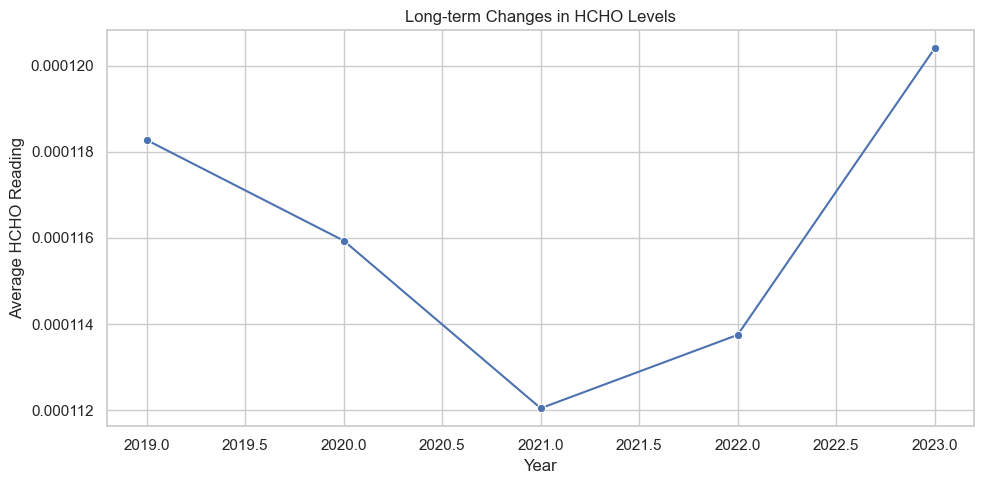

In [ ]:
# Plotting long-term changes
plt.figure(figsize=(10, 5))
sns.lineplot(x='Year', y='HCHO Reading', data=long_term_trend, marker='o')
plt.title('Long-term Changes in HCHO Levels')
plt.xlabel('Year')
plt.ylabel('Average HCHO Reading')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Filtering data for major cities and 2019-2020 period for COVID-19 lockdown analysis
cities = concatenated_dataset['Location'].unique()
covid_period_data = concatenated_dataset[(concatenated_dataset['Year'] >= 2020) & (concatenated_dataset['Year'] <= 2021)]

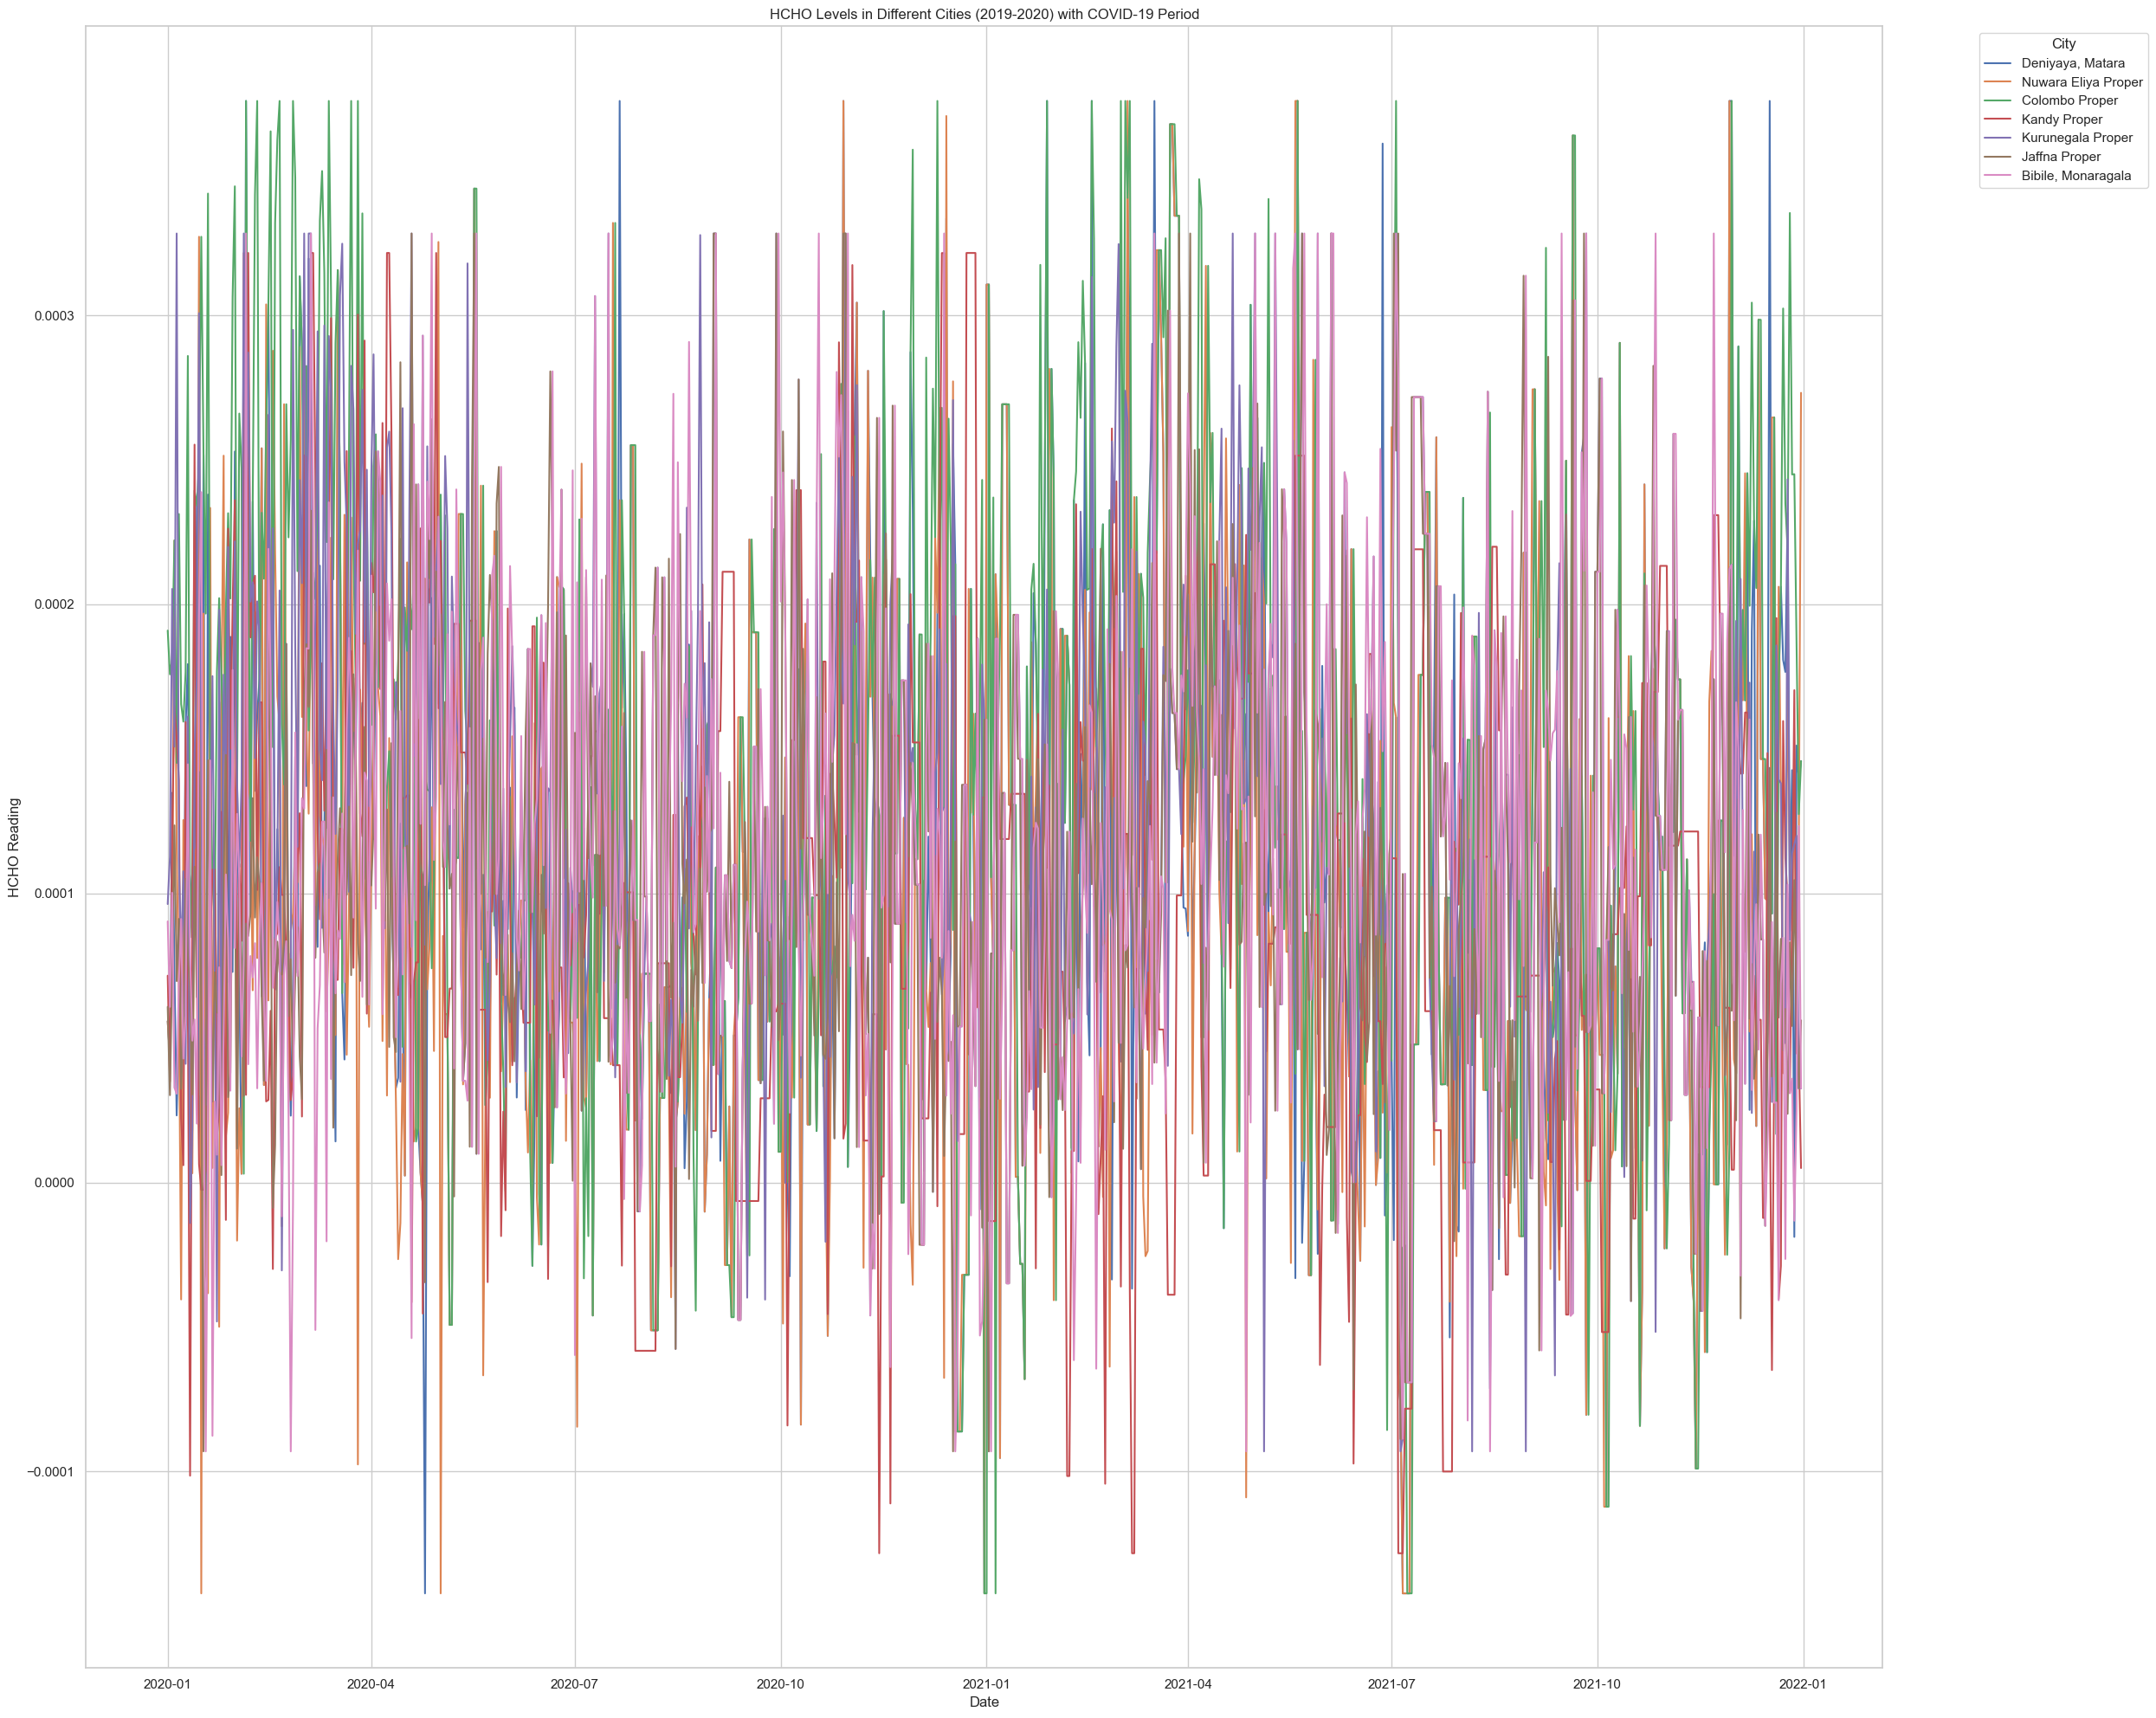

In [ ]:
# Plotting HCHO levels for different cities during 2019-2020
plt.figure(figsize=(25, 20))
for city in cities:
    city_data = covid_period_data[covid_period_data['Location'] == city]
    sns.lineplot(x='Current Date', y='HCHO Reading', data=city_data, label=city)
    
plt.title('HCHO Levels in Different Cities (2019-2020) with COVID-19 Period')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

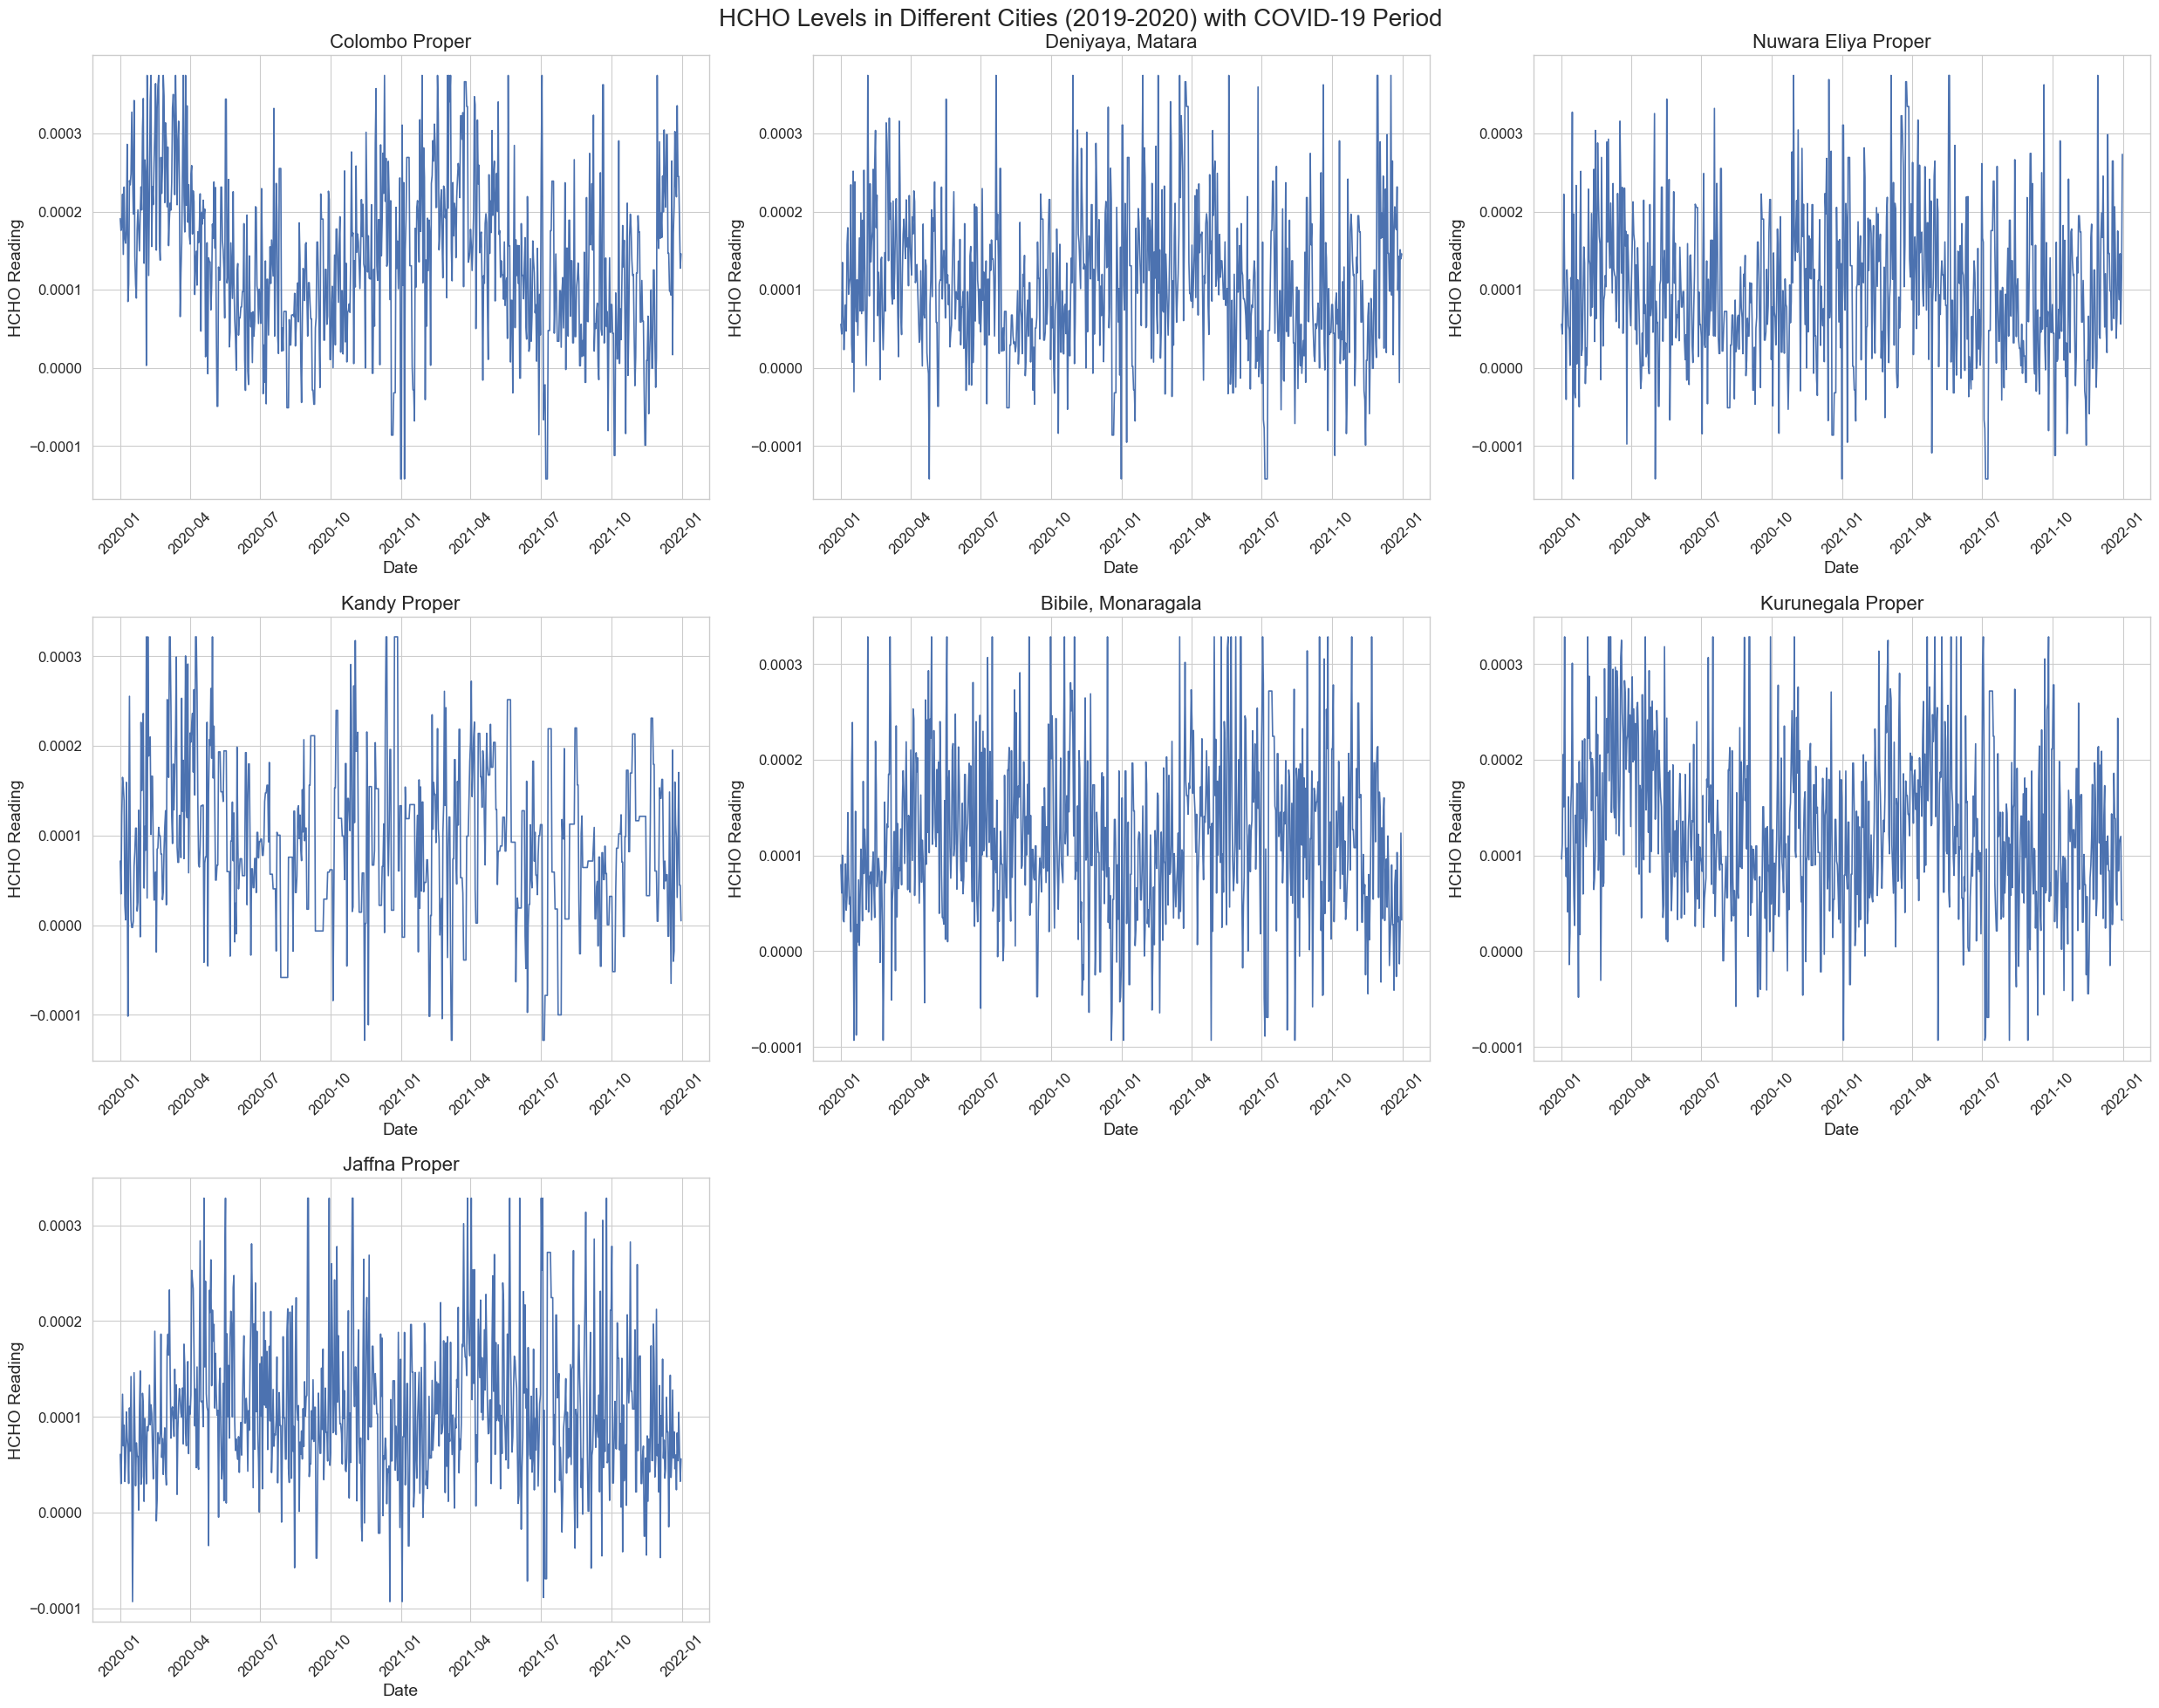

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Increase font sizes for better readability
sns.set_context("paper", font_scale=1.5)

plt.figure(figsize=(25, 20))  # Increase figure size

cities = covid_period_data['Location'].unique()

for i, city in enumerate(cities, start=1):
    plt.subplot(3, 3, i)
    city_data = covid_period_data[covid_period_data['Location'] == city]
    sns.lineplot(x='Current Date', y='HCHO Reading', data=city_data)
    plt.title(city, fontsize=16)  # Increase title font size
    plt.xlabel('Date', fontsize=14)  # Increase x-axis label font size
    plt.ylabel('HCHO Reading', fontsize=14)  # Increase y-axis label font size
    plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis tick labels and increase font size
    plt.yticks(fontsize=12)  # Increase y-axis tick label font size

plt.suptitle('HCHO Levels in Different Cities (2019-2020) with COVID-19 Period', fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
concatenated_dataset

HCHO Reading             Location Current Date  Next Date  Year  Month  \
0          0.000263     Deniyaya, Matara   2019-01-01 2019-01-02  2019      1   
1          0.000263  Nuwara Eliya Proper   2019-01-01 2019-01-02  2019      1   
2          0.000263       Colombo Proper   2019-01-02 2019-01-03  2019      1   
3          0.000006     Deniyaya, Matara   2019-01-02 2019-01-03  2019      1   
4          0.000006  Nuwara Eliya Proper   2019-01-02 2019-01-03  2019      1   
...             ...                  ...          ...        ...   ...    ...   
12774      0.000158    Kurunegala Proper   2023-12-30 2023-12-31  2023     12   
12775      0.000117        Jaffna Proper   2023-12-30 2023-12-31  2023     12   
12776      0.000117   Bibile, Monaragala   2023-12-31 2024-01-01  2023     12   
12777      0.000065    Kurunegala Proper   2023-12-31 2024-01-01  2023     12   
12778      0.000065        Jaffna Proper   2023-12-31 2024-01-01  2023     12   

      Month-Year  
0        2019-01  
1        2019-01  
2        2019-01  
3        2019-01  
4        2019-01  
...          ...  
12774    2023-12  
12775    2023-12  
12776    2023-12  
12777    2023-12  
12778    2023-12  

[12779 rows x 7 columns]